In [1]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.signal as sig
from systemprbm import UnitCell, System
import prbm_helper_functions as phf

from scipy.interpolate import UnivariateSpline
%matplotlib inline
from ECA_plotting import *
from ElementaryCA import *
from matplotlib.animation import FuncAnimation

In [2]:
params = phf.define_params()
rule_dict = separable_rules()

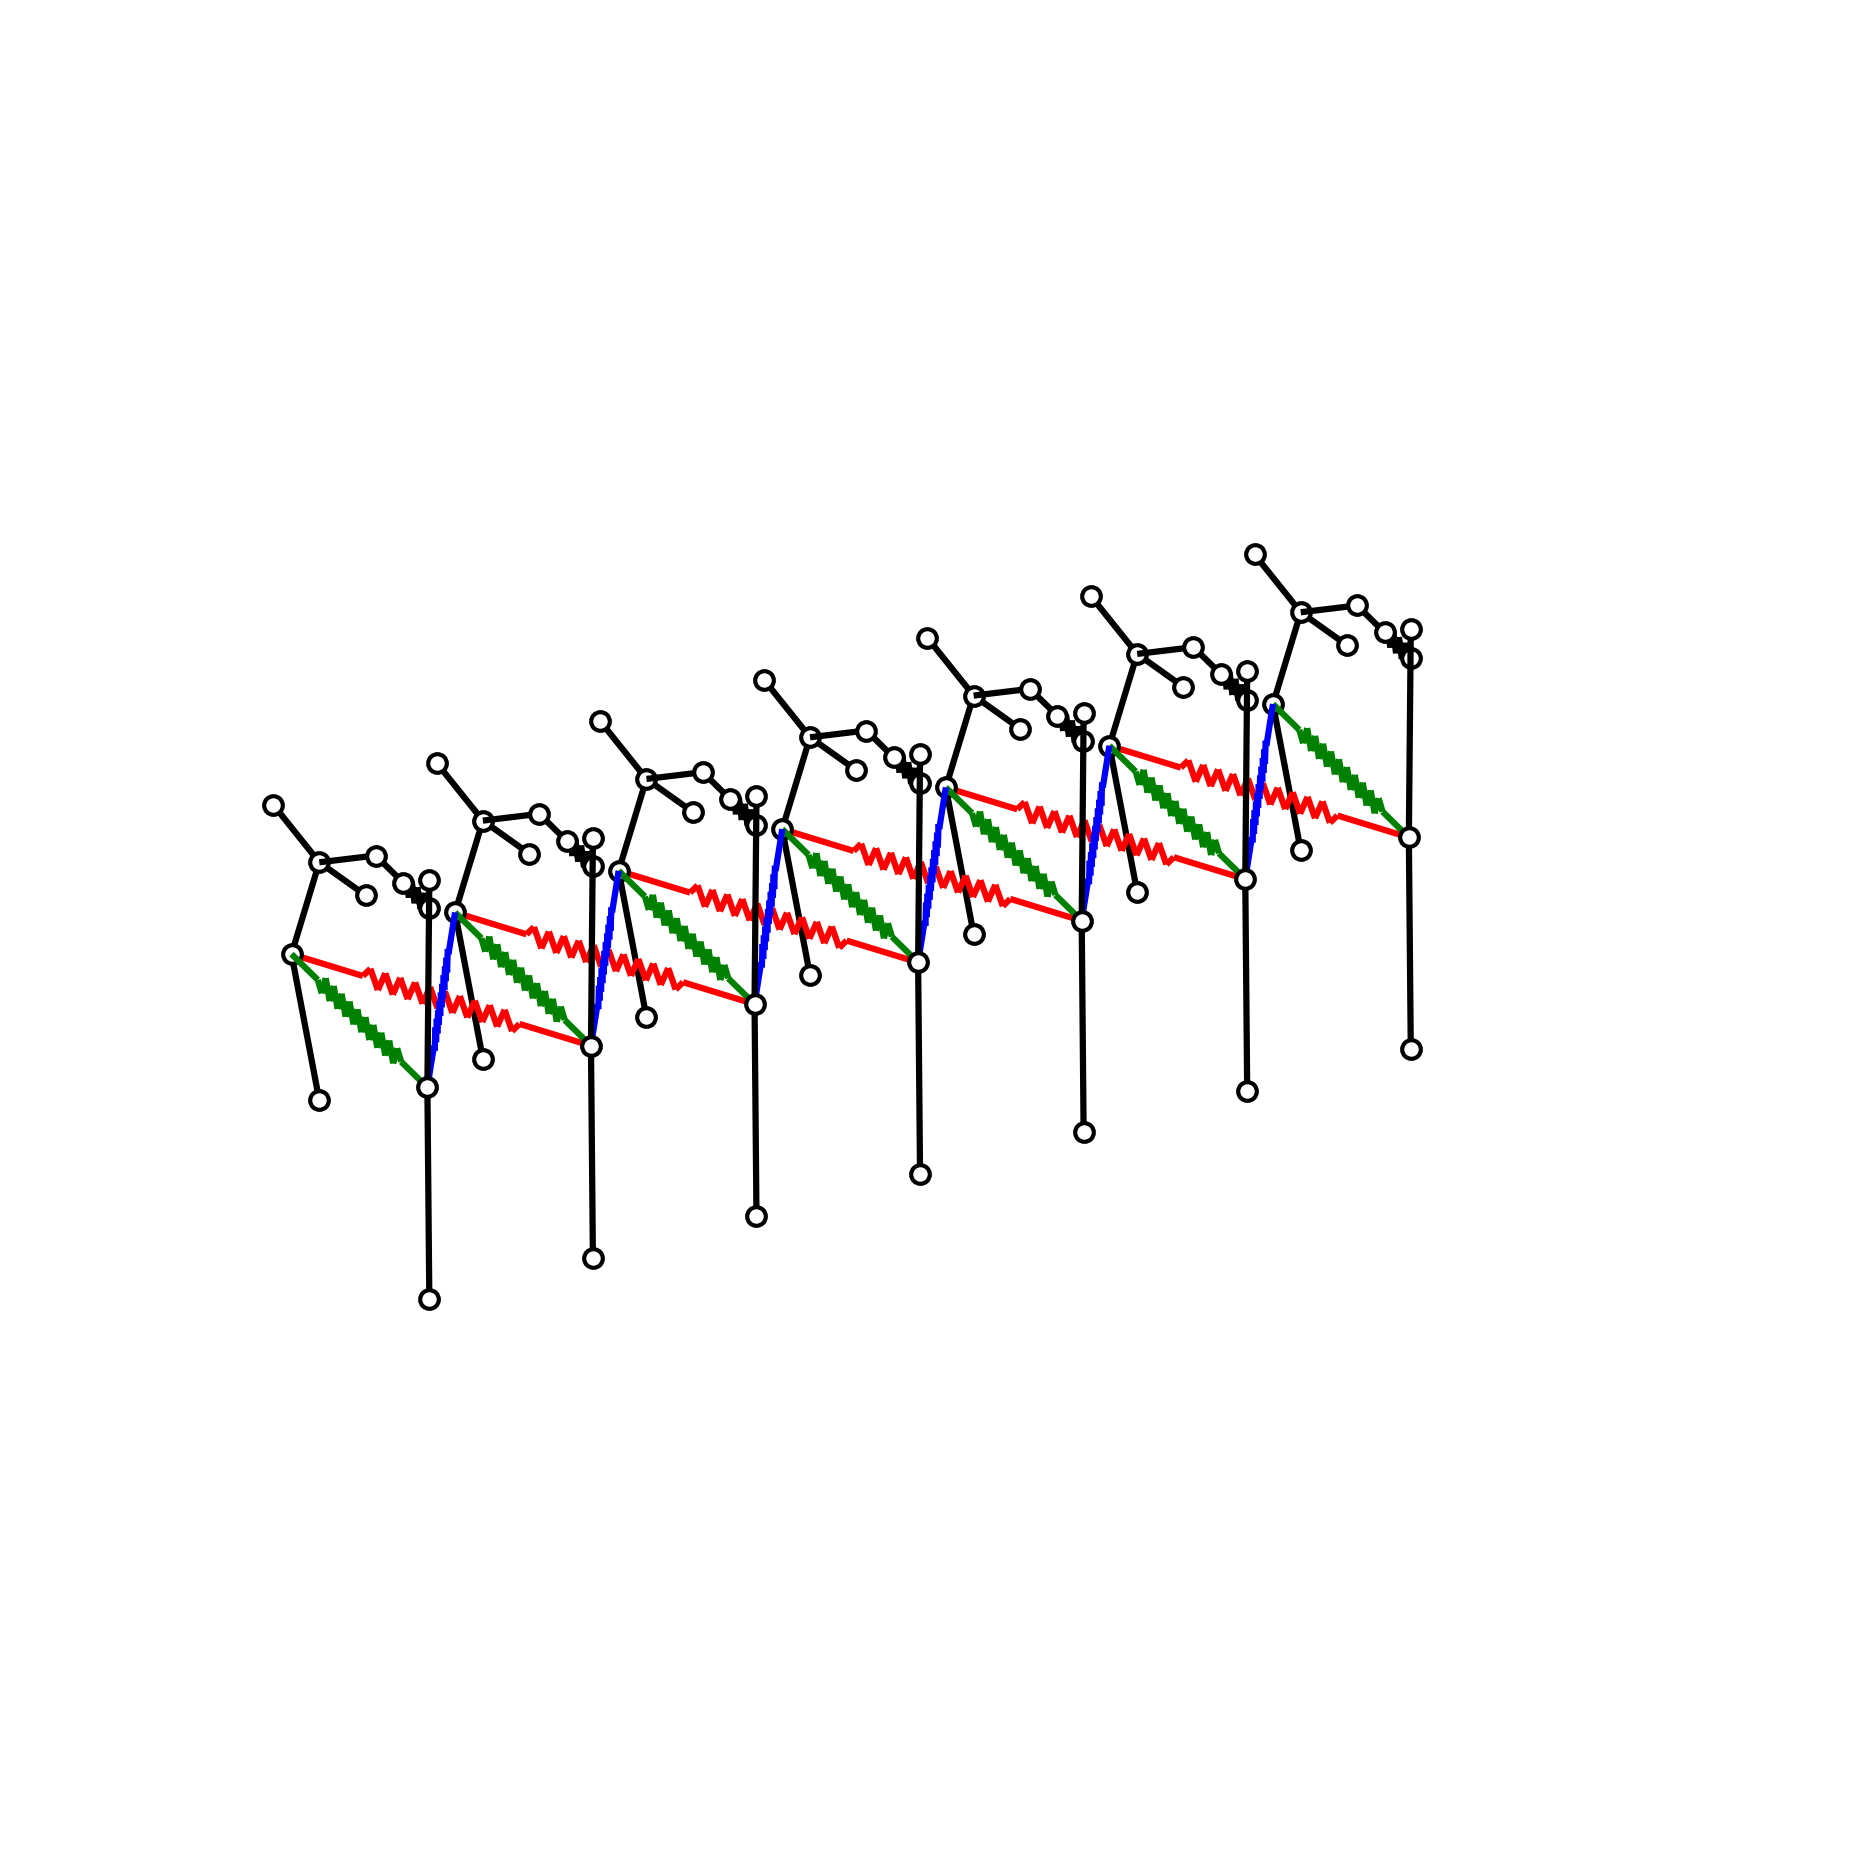

In [3]:
config = [0]*7
system = System(config,params)
system.cell_spacing = 50e-3
# system.update_state([alpha0,theta0])
fig, ax = system.plot_system()
fig.set_size_inches(6,6)
fig.set_dpi(300)
ax.set_position((0,0,1,1))
ax.view_init(elev=30,azim=-27)

# ax.collections[0].set_edgecolor('k')
# ax.collections[0].set_linewidth(2)
# ax.collections[1].set_visible(False)
# ax.collections[3].set_visible(True)
# system.signal_router_joints[0].set_visible(False)



In [4]:
config = [0,0,0,0]
system = System(config, params)






In [5]:

force_response,d0 = system.get_force_response()
spline = UnivariateSpline(d0, force_response, s=0)
spline_derivative = spline.derivative()
slopes = system.get_threshold_stiffnesses(d6max=35e-3)
slopes2 = system.get_threshold_stiffnesses(d6max=29.5e-3)

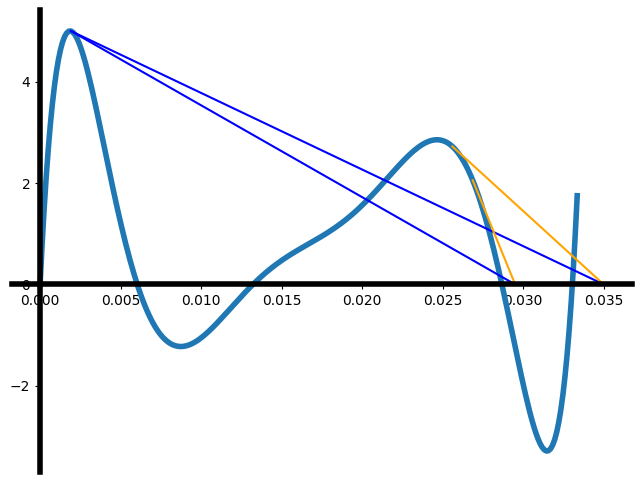

In [6]:

fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
plt.plot(d0,force_response,lw=4)
plt.plot([slopes[0][0],35e-3],[spline(slopes[0][0]),0],'-',ms=10,color='blue')
plt.plot([slopes[1][0],35e-3],[spline(slopes[1][0]),0],'-',ms=10,color='orange')
plt.plot([slopes2[0][0],29.5e-3],[spline(slopes2[0][0]),0],'-',ms=10,color='blue')
plt.plot([slopes2[1][0],29.5e-3],[spline(slopes2[1][0]),0],'-',ms=10,color='orange')
#set no ticks, spine going through the origin, no frame
# ax.set_xticks([])
# ax.set_yticks([])
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Hide the top and right spines





In [7]:
d6range = np.linspace(28.7e-3,35e-3,50)
slopes = []
for d6 in d6range:
    slopes.append(system.get_threshold_stiffnesses(d6max=d6))
slopes = np.array(slopes)
slopes = slopes[:,:,2]


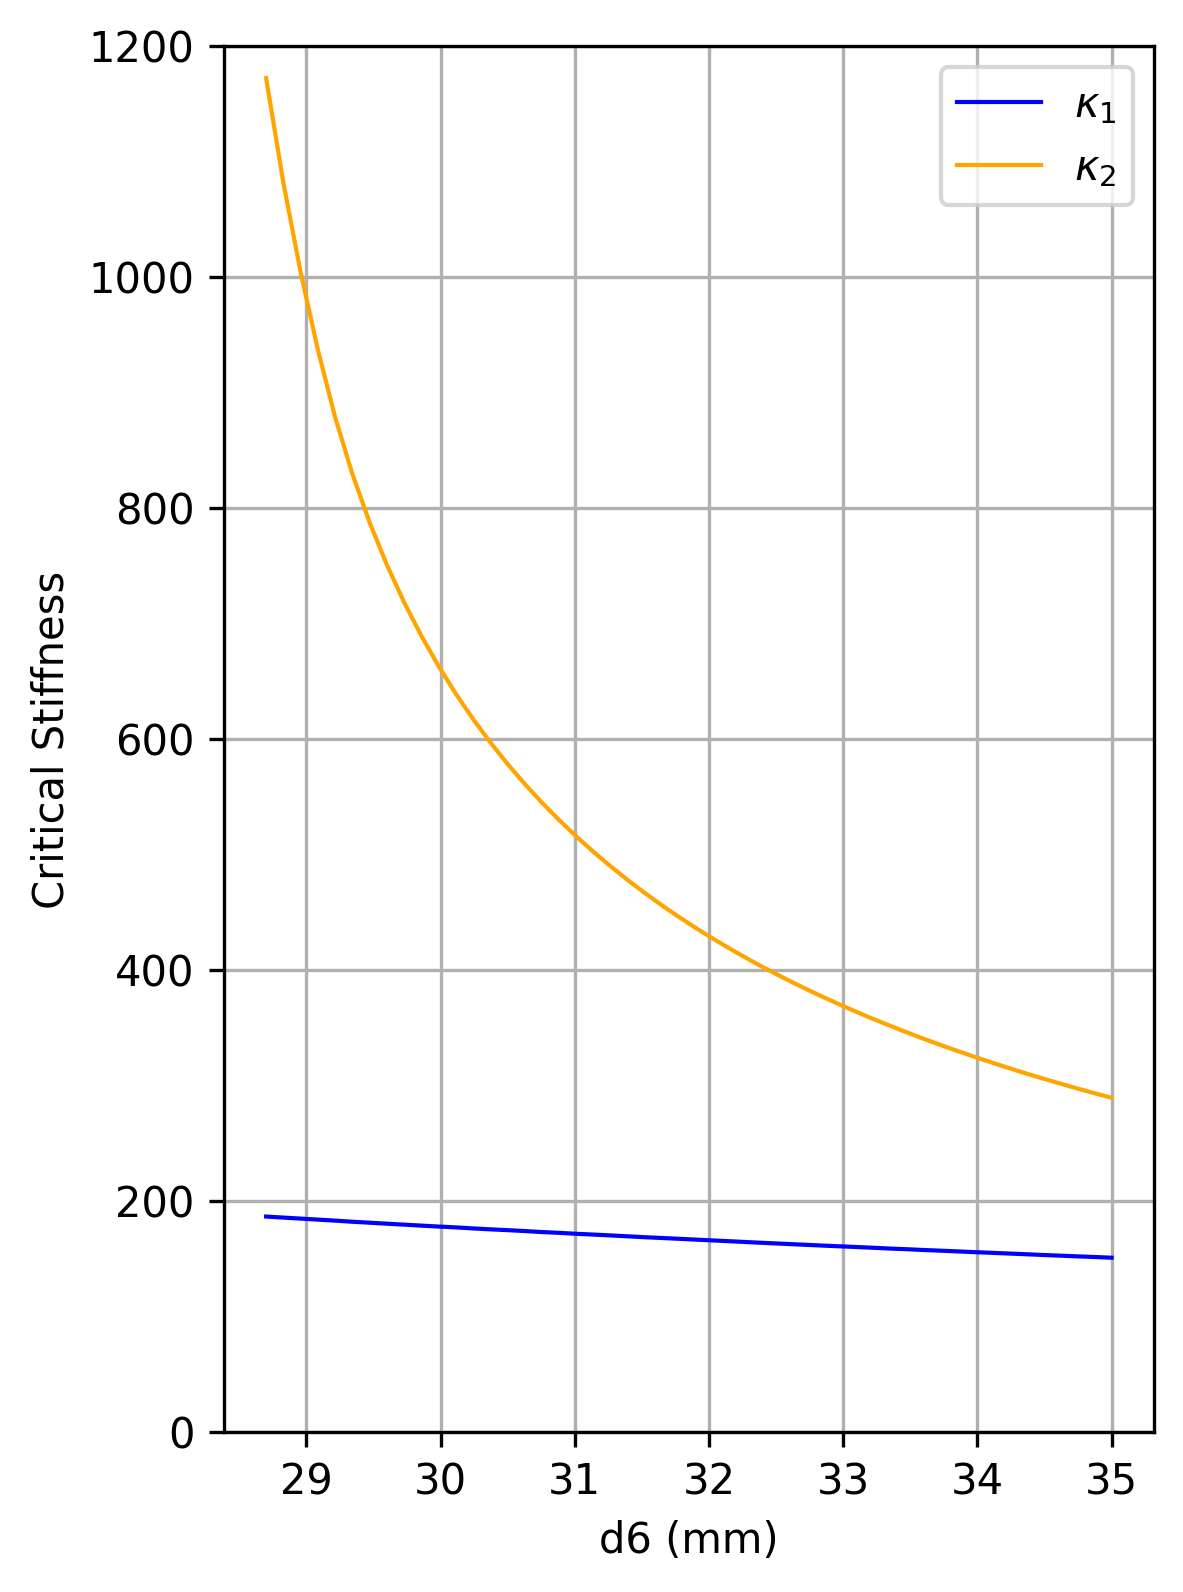

In [11]:

fig = plt.figure(figsize=(4, 6), dpi=300)
ax = fig.add_subplot(111)
plt.plot(d6range*1000,-slopes[:,0],lw=1,color='blue')
plt.plot(d6range*1000,-slopes[:,1],lw=1,color='orange')
ax.set_xlabel('d6 (mm)')
ax.set_ylabel('Critical Stiffness')
ax.legend(['$\kappa_1$','$\kappa_2$'])
ax.set_ylim([0,1200])
ax.grid(True)


Text(0, 0.5, 'Stiffness Ratio')

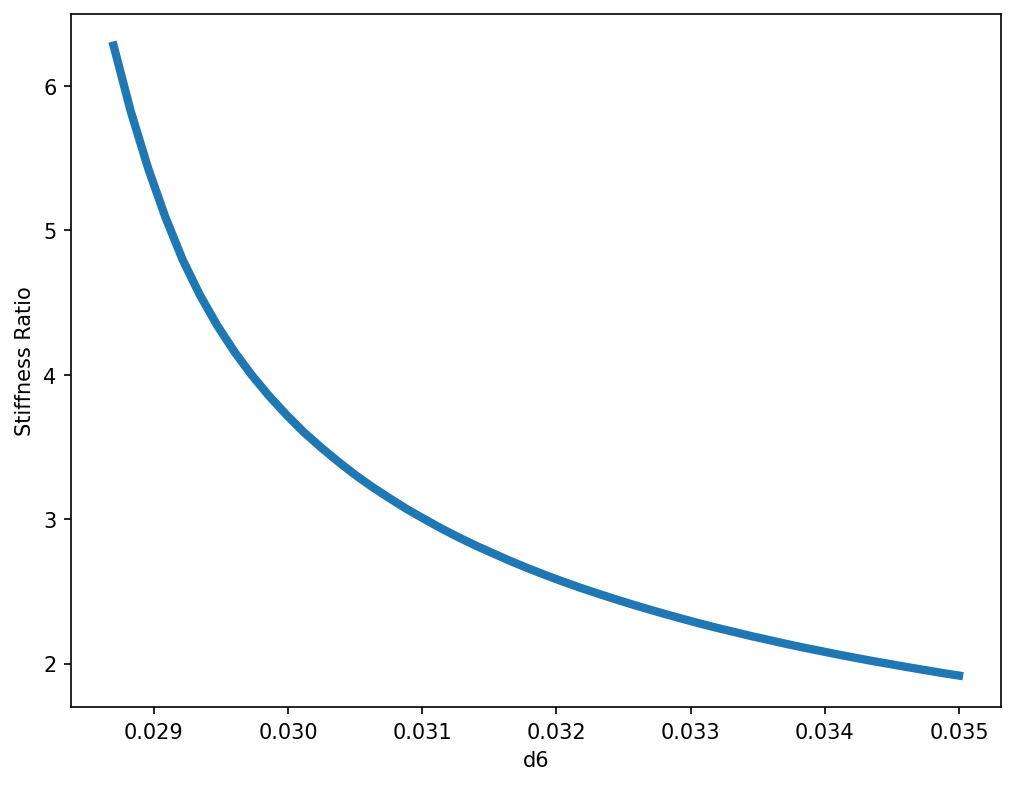

In [10]:
#plot ratio of slopes
from scipy.interpolate import CubicSpline
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(111)

stiffness_ratio = slopes[:,1]/slopes[:,0]
stiffness_ratio_spline = UnivariateSpline(d6range, stiffness_ratio, s=0)
slopes_spline = UnivariateSpline(d6range, -slopes[:,0], s=0)
# stiffness_ratio_spline_inverse = CubicSpline(stiffness_ratio,d6range)
plt.plot(d6range,stiffness_ratio,lw=4)
ax.set_xlabel('d6')
ax.set_ylabel('Stiffness Ratio')


In [11]:
rule = rule_dict[110]
print(rule)
x=  rule[1][1]/rule[1][0]
bounds = [(28.7e-3, 35e-3)]
result = minimize(lambda d6: abs(stiffness_ratio_spline(d6) - x), 30e-3, bounds=bounds)
d6 = result.x[0]

print(f'd6 (mm) = {d6*1000:.2f}')
k_crit = slopes_spline(d6)
print(f'K_crit (N/m) = {k_crit:.2f}')
stiffnesses = rule[0]*slopes_spline(d6)/rule[1][0]
print(f'K1 (N/m) = {stiffnesses[0]:.2f}')
print(f'K2 (N/m) = {stiffnesses[1]:.2f}')
print(f'K3 (N/m) = {stiffnesses[2]:.2f}')


([1, 2, 2], (1.5, 4.5))
d6 (mm) = 31.02
K_crit (N/m) = 171.71
K1 (N/m) = 114.47
K2 (N/m) = 228.94
K3 (N/m) = 228.94


In [12]:
x = 3


<Figure size 640x480 with 0 Axes>

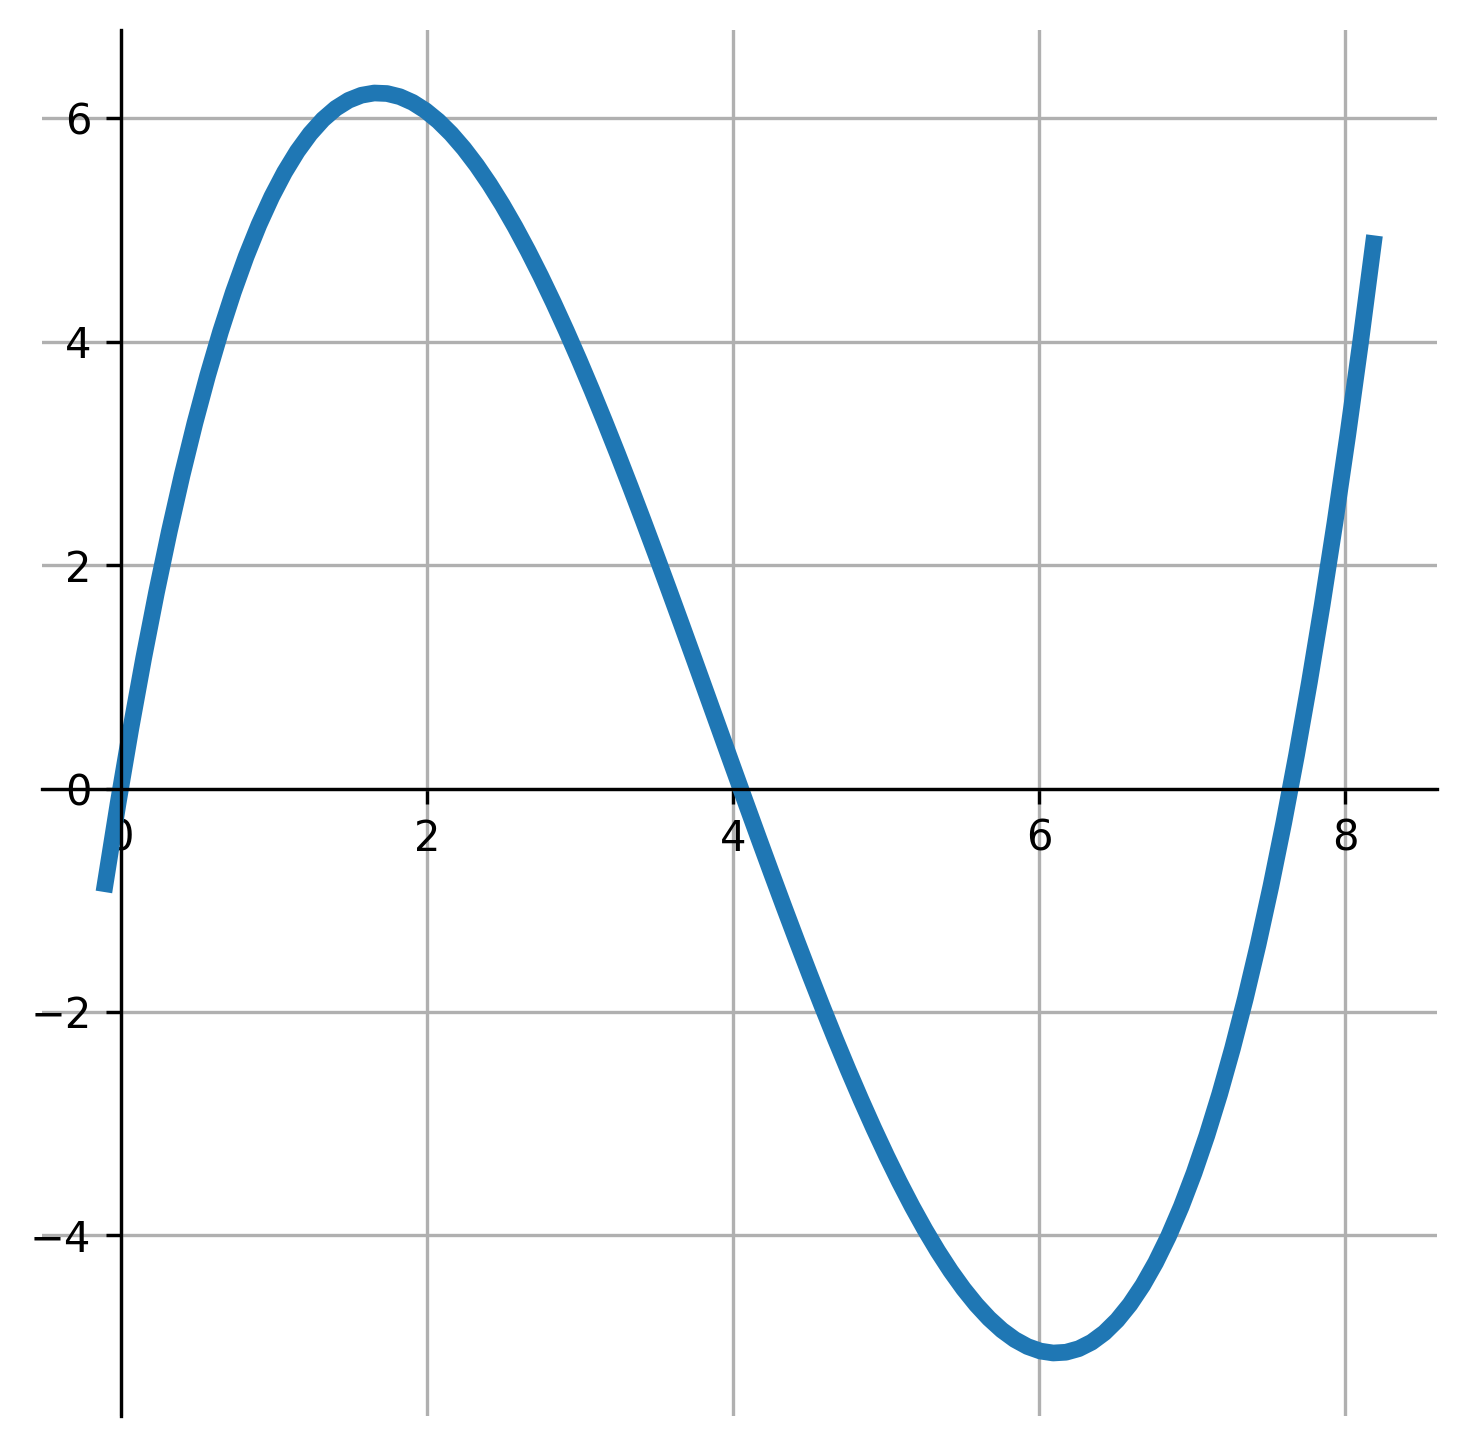

In [17]:
from bistableprbm import Bistable
%run bistableprbm.py

bistable = Bistable(0, params)

d1_range = np.linspace(-0.1e-3,1.05*params['L2']*np.sin(params['beta0'])*2,100)
force = []
for d1 in d1_range:
    bistable.update_state(d1)
    force.append(bistable.compute_force_residuals())
fig,ax = plt.subplots(figsize=(6, 6), dpi=300)
plt.plot(d1_range*1000,force,lw=4)
# ax.set_xticks([])
# ax.set_yticks([])
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.grid(True)   


# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [18]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

ps = powerset([params['K1'],params['K2'],params['K3']])

ps = list(ps)
sums =[sum(x) for x in ps if x]
sums

[0, 0, 0, 0, 0, 0, 0]

In [19]:
%run ECA_plotting.py
from ECA_plotting import *

<Figure size 640x480 with 0 Axes>

-0.46739519232854154
[(0.00191070296799364, 4.997905228167301, -166.1024258177573), (0.025983467730157677, 2.5835639640066383, -429.41080478478784)]
m1 = 166.1024258177573, m2 = 429.41080478478784
K1 = 140, K2 = 180, K3 = 175


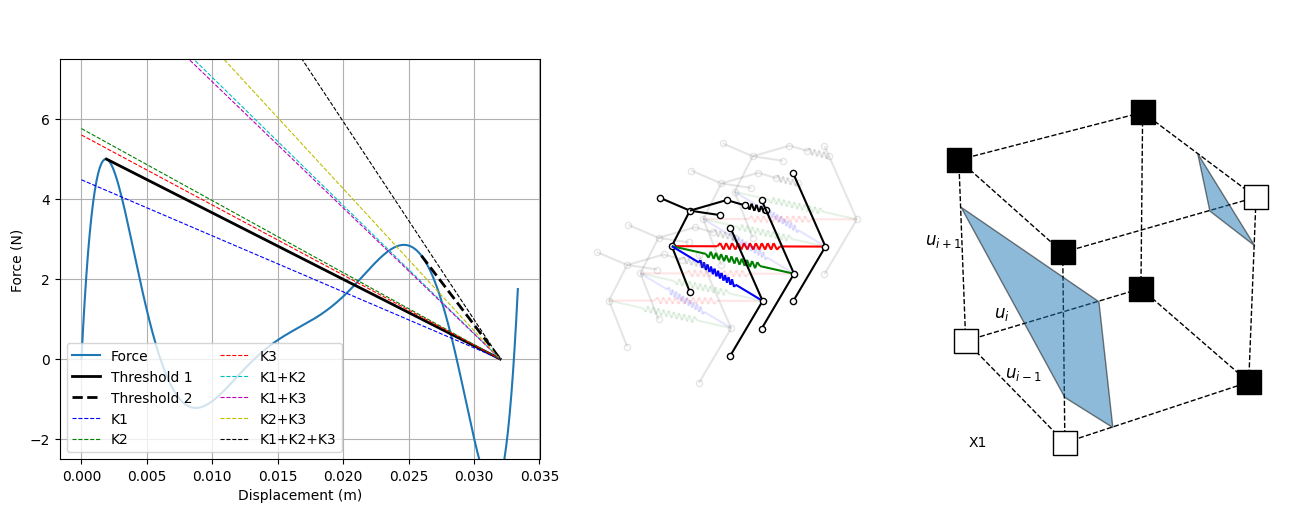

In [20]:
plt.close()
params['K1'] = 140
params['K2'] = 180
params['K3'] = 175
d6 = 32e-3
theta_max = np.arcsin(np.sin(params['theta0']-d6/params['L4']))
print(theta_max)


fig = plt.figure(figsize=(16,5))
ax2 = fig.add_subplot(132, projection='3d')
ax1 = fig.add_subplot(131)


config = [0,0,0,0,0]
system = System(config,params)
system.cell_spacing = 0.5e-1
x= system.state_vector
x[1::2] = theta_max
system.update_state(x)
system.plot_system(fig= fig, ax=ax2)
ax2.view_init(azim=-60, elev=30)



for i in [0,1,3,4]:
    system.tristable_lines[i].set_alpha(0.1) 
    system.tristable_joints[i].set_alpha(0.1)
    system.signal_router_lines[i].set_alpha(0.1)
    system.signal_router_joints[i].set_alpha(0.1)
    system.signal_spring_lines[i].set_alpha(0.1)
    system.self_spring_lines[i].set_alpha(0.1)
    try:
        system.left_spring_lines[i].set_alpha(0.1)
    except:
        pass
    try:
        system.right_spring_lines[i].set_alpha(0.1)
    except:
        pass
for i in [0,4]:
    system.bifurcation_lines[i].set_alpha(0.1)
    system.bifurcation_joints[i].set_alpha(0.1)



ax1.plot(d0,force_response)
ax1.grid()
ax1.set_xlabel('Displacement (m)')
ax1.set_ylabel('Force (N)')

results = phf.find_tangent_lines(np.column_stack((d0, force_response)),(d6,0))
print(results)
ax1.plot((results[0][0],d6),(results[0][1],0),'k-',linewidth=2)
ax1.plot((results[1][0],d6),(results[1][1],0),'k--',linewidth=2)

ps = powerset([params['K1'],params['K2'],params['K3']])
ps = list(ps)
sums =[sum(x) for x in ps if x]
colors = ['b','g','r','c','m','y','k']
for c,num in zip(colors,sums):
    ax1.plot((0,d6),(num*d6,0),c+'--',linewidth=0.8)
#set ylimits
ax1.set_ylim([-2.5,7.5])
ax1.legend(['Force','Threshold 1','Threshold 2','K1','K2','K3','K1+K2','K1+K3','K2+K3','K1+K2+K3'], loc='lower left', ncol=2)

ax3 = fig.add_subplot(133,projection='3d')
#find slopes of lines
m1 = -results[0][2]
m2 = -results[1][2]
plotSetup(fig=fig, ax=ax3)
drawCube(ax3)
print(f'm1 = {m1}, m2 = {m2}')
print(f'K1 = {params["K1"]}, K2 = {params["K2"]}, K3 = {params["K3"]}')
# plot_cube_with_planes(ax3,[params['K1']*2,params['K2'],params['K3']],m1,m2)
plot_cube_with_planes(ax3,[1,2,2],1.5,4.5)
ax3.set_xlabel('X1')


ax1.set_position([0.1,0.1,0.3,0.8])
ax2.set_position([0.15,0,0.75,1])
ax3.set_position([0.6,0.1,0.3,0.8])


In [21]:
from scipy.interpolate import interp1d

krange = [75,300]
thickness = interp1d(krange,[0.1,5.0])

In [22]:
def generate_wavelet(n, points, s,w, mid_point,scale=1):
    K1_vals = np.ones(n)
    vec2 = sig.morlet(points, s,w).imag*scale
    p1 = int(mid_point*(n-points))
    K1_vals[p1:p1+points] = vec2+1
    return K1_vals

frames = 300
points = 160
s = 0.5
w = 0.8

params['K1'] = 140
params['K2'] = 180
params['K3'] = 175
K1_vals = params['K1']*generate_wavelet(frames, points, s,w, 0,2)
K2_vals = params['K2']*generate_wavelet(frames, points, s,w, 0.5,2)
K3_vals = params['K3']*generate_wavelet(frames, points, s,w, 1,2)





In [23]:
def update(i):

    params['K1'] = K1_vals[i]
    params['K2'] = K2_vals[i]
    params['K3'] = K3_vals[i]
    d6 = d6_vals[i]
    theta_max = np.arcsin(np.sin(params['theta0']-d6/params['L4']))
    state = system.state_vector
    state[1::2] = theta_max
    
    # system.update_plot(0,[state])
    
    

    # d6 = d6_vals[i]
    force_response,d0 = system.get_force_response()
    ax1.cla()
    ax1.plot(d0,force_response)
    ax1.grid()
    results = phf.find_tangent_lines(np.column_stack((d0, force_response)),(d6,0))
    ax1.plot((results[0][0],d6),(results[0][1],0),'k-',linewidth=2)
    ax1.plot((results[1][0],d6),(results[1][1],0),'k--',linewidth=2)
    ps = list(powerset([params['K1'],params['K2'],params['K3']]))
    sums =[sum(x) for x in ps if x]
    colors = ['b','g','r','c','m','y','k']
    for c,num in zip(colors,sums):
        ax1.plot((0,d6),(num*d6,0),c+'--',linewidth=0.8)
    ax1.set_ylim([-2.5,7.5])
    ax1.legend(['Force','Threshold 1','Threshold 2','K1','K2','K3','K1+K2','K1+K3','K2+K3','K1+K2+K3'], loc='lower left', ncol=2)

    for i in range(system.n):
        system.self_spring_lines[i].set_linewidth(thickness(params['K2']))
        try:
            system.left_spring_lines[i].set_linewidth(thickness(params['K1']))
        except:
            pass
        try:
            system.right_spring_lines[i].set_linewidth(thickness(params['K3']))
        except:
            pass

    ax3.cla()
    m1 = -results[0][2]
    m2 = -results[1][2]

    
    plotSetup(fig=fig, ax=ax3)
    drawCube(ax3)
    plot_cube_with_planes(ax3,[params['K1'],params['K2'],params['K3']],m1,m2)
    
    
    


In [24]:
frames = 300
points = 160
s = 0.5
w = 0.8

params['K1'] = 140
params['K2'] = 180
params['K3'] = 175
K1_vals = params['K1']*generate_wavelet(frames, points, s,w, 0,2)
K2_vals = params['K2']*generate_wavelet(frames, points, s,w, 0.5,2)
K3_vals = params['K3']*generate_wavelet(frames, points, s,w, 1,2)
d6_vals = d6*np.ones(frames)


# plt.plot(thickness(K1_vals), label='K1')
# plt.plot(thickness(K2_vals), label='K2')
# plt.plot(thickness(K3_vals), label='K3')

ani = FuncAnimation(fig, update, frames=len(K1_vals), interval=100, repeat=False)
ani.save('dstiffness_sweep.mp4',writer='ffmpeg',fps=30)

KeyboardInterrupt: 

In [ ]:
params['K1'] = 140
params['K2'] = 180
params['K3'] = 175

frames = 200
points = 200
s = 0.5
w = 0.8
d6_vals = d6*generate_wavelet(frames, points, s,w, 0,0.2)
K1_vals = params['K1']*np.ones(frames)
K2_vals = params['K2']*np.ones(frames)
K3_vals = params['K3']*np.ones(frames)



In [ ]:
ani = FuncAnimation(fig, update, frames=len(K1_vals), interval=100, repeat=False)

In [ ]:
ani.save('d6_sweep.mp4',writer='ffmpeg',fps=30)

[(0.0019224025784862623, array(4.99679854), -166.13029300090426), (0.025983494596529152, array(2.58355102), array(-429.41044865))]
[(0.0019224025784862623, array(4.99679854), -166.13029300090426), (0.025983494596529152, array(2.58355102), array(-429.41044865))]
[(0.0019224025784862623, array(4.99679854), -166.1303098932099), (0.025983447347005056, array(2.58357131), array(-429.39270341))]
[(0.0019224025784862623, array(4.99679854), -166.13033200453077), (0.02598348687556829, array(2.58355433), array(-429.40754893))]
[(0.0019224025784862623, array(4.99679854), -166.13036082993992), (0.025983496969929035, array(2.58355), array(-429.41134002))]
[(0.0019224025784862623, array(4.99679854), -166.1303982583595), (0.025983489241138965, array(2.58355332), array(-429.40843735))]
[(0.0019224025784862623, array(4.99679854), -166.1304466666529), (0.025983499972937203, array(2.58354871), array(-429.41246785))]
[(0.0019224025784862623, array(4.99679854), -166.13050903362026), (0.02598349921375467, ar

ECA Plotting

In [ ]:
%run ECA_plotting.py

<Figure size 640x480 with 0 Axes>

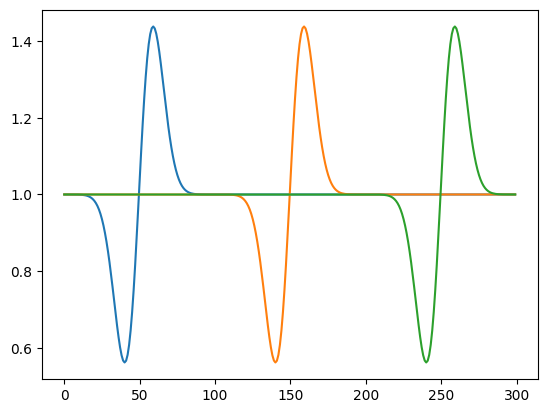

In [ ]:
frames = 300
points = 100
s = 0.5
w = 0.8


K1_vals = generate_wavelet(frames, points, s,w, 0,2)
K2_vals = generate_wavelet(frames, points, s,w, 0.5,2)
K3_vals = generate_wavelet(frames, points, s,w, 1,2)



plt.plot(K1_vals, label='K1')
plt.plot(K2_vals, label='K2')
plt.plot(K3_vals, label='K3')

Text(0.5, 0, 'B')

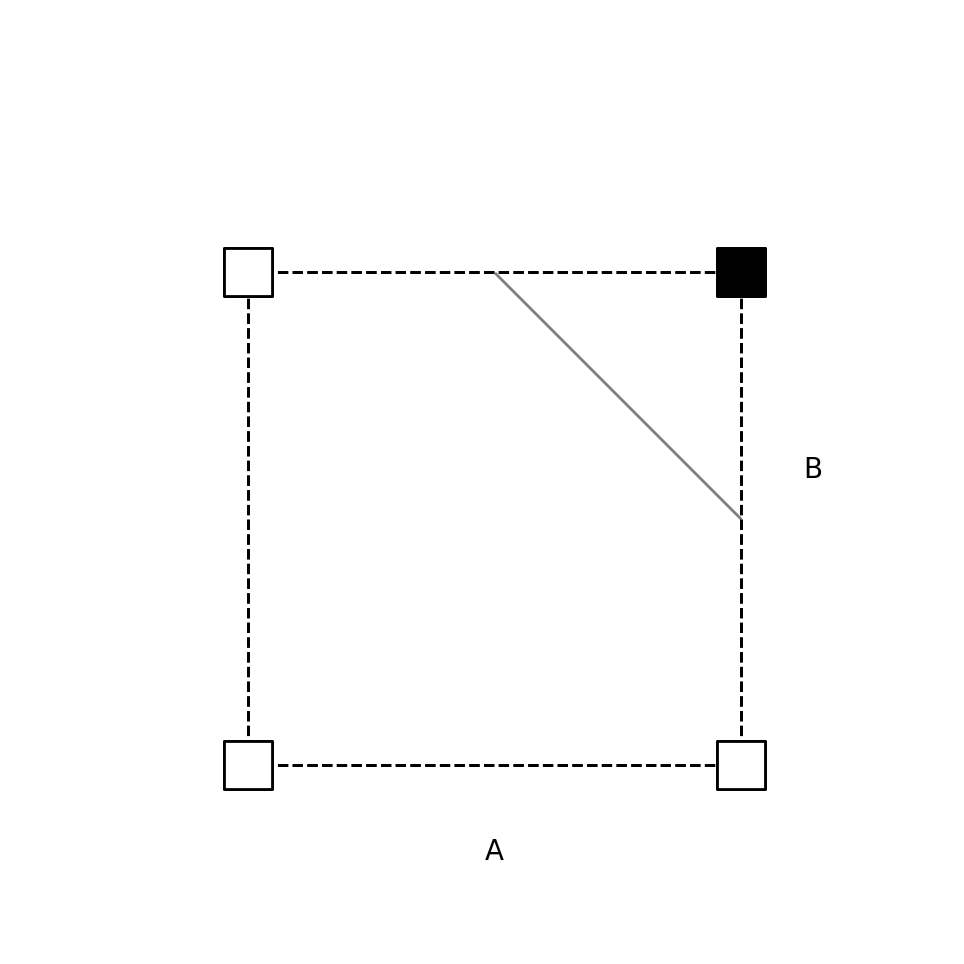

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8, 6), dpi=200,subplot_kw={'projection': '3d'})

plotSetup(fig=fig,ax=ax,proj = 'ortho',elev=0, azim=0)
drawCube(fig.axes[0],r=[0,1])
plns = plot_cube_with_planes(ax,[0,1,1],1.5,10)
ax.set_proj_type('ortho')
ax.set_xlabel('',labelpad=0)
ax.set_ylabel('A',labelpad=0)
ax.set_zlabel('B',labelpad=0)



In [ ]:
def update(i):
    if i==1:
        ax.set_xlabel('C',labelpad=0)
    ax.view_init(elev=-.3*i, azim=360-.3*i)

ani = FuncAnimation(fig, update, frames=100, interval=100)
ani.save('test.gif', writer='ffmpeg', fps=30)

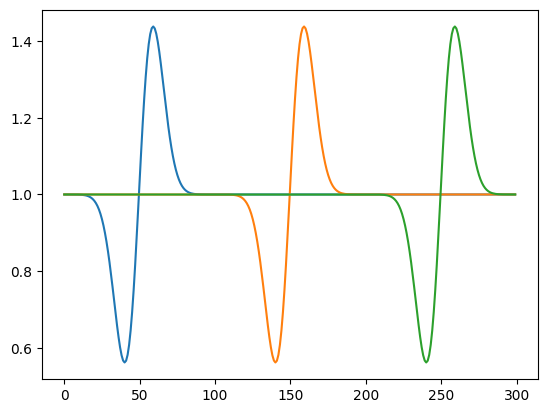

In [ ]:
frames = 300
points = 100
s = 0.5
w = 0.8


K1_vals = generate_wavelet(frames, points, s,w, 0,2)
K2_vals = generate_wavelet(frames, points, s,w, 0.5,2)
K3_vals = generate_wavelet(frames, points, s,w, 1,2)



plt.plot(K1_vals, label='K1')
plt.plot(K2_vals, label='K2')
plt.plot(K3_vals, label='K3')

Text(0.5, 0, 'C')

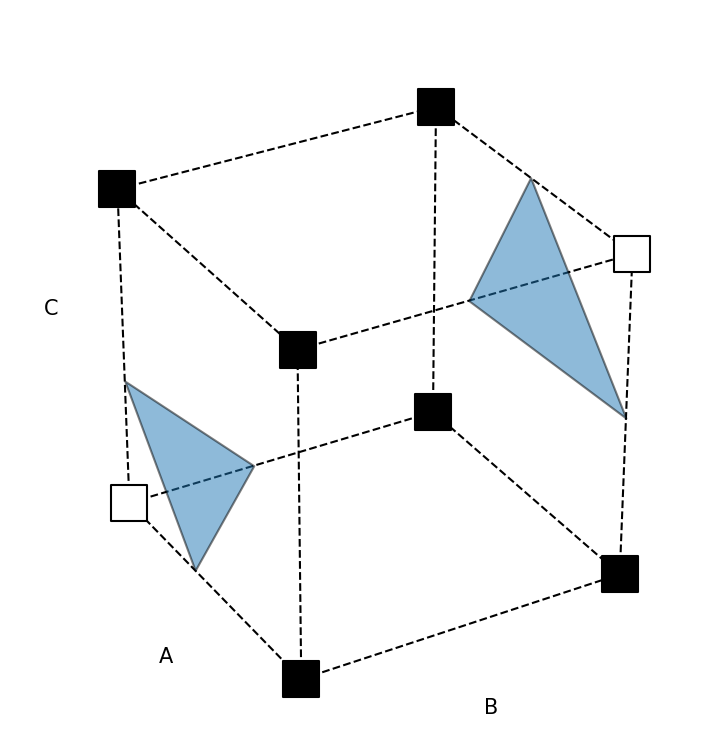

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8, 6), dpi=150,subplot_kw={'projection': '3d'})

plotSetup(fig=fig,ax=ax,proj = 'ortho',elev=30, azim=330)
drawCube(fig.axes[0],r=[0,1])
plns = plot_cube_with_planes(ax,[1,1,1],0.4,2.5)
ax.set_xlabel('A',labelpad=0)
ax.set_ylabel('B',labelpad=0)
ax.set_zlabel('C',labelpad=0)

In [ ]:

def update(i):
    ax.cla()

    
    plotSetup(fig=fig,ax=ax,proj = 'ortho',elev=30, azim=300)
    drawCube(ax)
    plot_cube_with_planes(ax,[K1_vals[i],K2_vals[i],K3_vals[i]],1.7,5)

In [ ]:
ani = FuncAnimation(fig, update, frames=len(K1_vals), interval=100)
ani.save('stiffness_jiggle.mp4', writer='ffmpeg', fps=5)

NameError: name 'FuncAnimation' is not defined